In [1]:
#@markdown ### **Imports**
# diffusion policy import
from typing import Any, Dict, Union, List, Generator, Optional

import os
import glob
import pickle
import pathlib
import numpy as np
import pandas as pd
from torch.utils.data import IterableDataset
from copy import deepcopy


import cv2
import pandas as pd
import os
import sys

import matplotlib.pyplot as plt

# data imports
from  src.dataset import get_dataset_pusht
# model imports
from src.policy import get_action_diffusion_model, load_checkpoint 
# train import
from src.train import train_diff_model
# env import
from src.envs.sim_pusht import PushTImageEnv
# rollout import
from src.rollout import rollout

import glob

### Report the success rate in the dataset

In [2]:
data_set_path = "logs/datasets/no_domain_randomization_v8_simple_env"

all_episodes = glob.glob(os.path.join(data_set_path, "*episode*.pkl"))
success_ep_paths = glob.glob(os.path.join(data_set_path, "*success.pkl"))
failure_ep_paths = glob.glob(os.path.join(data_set_path, "*failure.pkl"))

success_rate = len(success_ep_paths) / len(all_episodes)
print(f"Success rate: {success_rate:.2f}")

Success rate: 0.48


In [63]:
df = pd.read_pickle(success_ep_paths[0])

df.columns

Index(['timestep', 'rgb', 'reward', 'sampled_actions', 'executed_action',
       'action_index', 'agent_positions', 'agent_velocities', 'block_poses',
       'goal_poses', 'step_image_features', 'step_agent_poses', 'success',
       'episode'],
      dtype='object')

### Define Episode Dataset Class

In [6]:
def load_pickle(path: Union[str, pathlib.Path]) -> pd.DataFrame:
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data

class EpisodeDataset(IterableDataset):

    def __init__(
        self,
        dataset_path: Union[str, pathlib.Path],
        exec_horizon: int,
        sample_history: int,
        filter_success: bool = False,
        filter_failure: bool = False,
        filter_episodes: Optional[List[int]] = None,
        max_episode_length: Optional[int] = None,
        max_num_episodes: Optional[int] = None,
    ) -> None:
        """Construct EpisodeDataset."""
        super().__init__()
        assert exec_horizon >= 1 and sample_history >= 0
        self._dataset_path = dataset_path
        self._episode_files = sorted(glob.glob(os.path.join(dataset_path, "*.pkl")))
        self._exec_horizon = exec_horizon
        self._sample_history = sample_history
        self._filter_success = filter_success
        self._filter_failure = filter_failure
        self._filter_episodes = filter_episodes
        self._max_episode_length = max_episode_length
        self._max_num_episodes = max_num_episodes

    def __iter__(
        self,
    ) -> Generator[Union[Dict[str, Any], List[Dict[str, Any]]], None, None]:
        """Return sample."""
        num_episodes = 0
        for i, file_path in enumerate(self._episode_files):
            # if self._max_num_episodes is not None and num_episodes >= self._max_num_episodes:
            if self._max_num_episodes is not None and i >= self._max_num_episodes:
                continue

            episode = load_pickle(file_path)
            success = episode.iloc[0].to_dict().get("success", True)
            if (
                (self._filter_success and success)
                or (self._filter_failure and not success)
                or (
                    self._filter_episodes is not None
                    and not isinstance(self._filter_episodes, str)
                    and i in self._filter_episodes
                )
            ):
                continue
            else:
                num_episodes += 1

            for idx in range(
                self._exec_horizon * self._sample_history,
                len(episode), # rows of data in episode df
                self._exec_horizon,
            ):
                if (
                    self._max_episode_length is not None
                    and episode.iloc[idx].to_dict()["timestep"]
                    >= self._max_episode_length
                ):
                    continue

                sample = [
                    episode.iloc[j].to_dict()
                    for j in range(
                        idx - self._exec_horizon * self._sample_history,
                        idx + 1,
                        self._exec_horizon,
                    )
                ]

                # if len(sample) < 2:
                #     continue
                # assert all(x["episode"] == i for x in sample), not relevant for our dataset
                yield sample[0] if len(sample) == 1 else sample

def get_latent_embedding(data, full= False, average=True):
    assert not (full and average), "Can't have both"

    image_feats = data['step_image_features']
    agent_pos = data['step_agent_poses']

    comb = np.concatenate([image_feats, agent_pos], axis=-1)

    if average:
        return comb.mean(axis=0)
    
    if full:
        return comb.flatten()

    return comb[-1]

### Acquire all embeddings and relative pose orthant for each timestep in a dataset


Orthant Labels:

| Label | (Δx sign, Δy sign, Δθ sign) | Meaning      |
| :---: | :-------------------------: | :----------- |
|   0   |          (–, –, –)          | all negative |
|   1   |          (–, –, +)          | only θ ≥ 0   |
|   2   |          (–, +, –)          | only y ≥ 0   |
|   3   |          (–, +, +)          | y,θ ≥ 0      |
|   4   |          (+, –, –)          | only x ≥ 0   |
|   5   |          (+, –, +)          | x,θ ≥ 0      |
|   6   |          (+, +, –)          | x,y ≥ 0      |
|   7   |          (+, +, +)          | all non‐neg  |


In [40]:
def orthant_label(pose):
    """
    pose: array-like of length 3 [dx, dy, dtheta]
    returns: int in [0..7] encoding the sign-pattern:
      bit2 (4) = (dx >= 0)
      bit1 (2) = (dy >= 0)
      bit0 (1) = (dtheta >= 0)
    """
    dx, dy, dth = pose
    b2 = int(dx  >= 0)
    b1 = int(dy  >= 0)
    b0 = int(dth >= 0)
    return (b2 << 2) | (b1 << 1) | b0

def get_relative_pose_label(data):
        goal_pose = data['goal_poses'][0]
        start_pose = data['block_poses'][0]

        goal_pos = goal_pose[:2]/512 # put into 0-1 range
        goal_rot = goal_pose[2]
        start_pos = start_pose[:2]/512 # put into 0-1 range
        start_rot = start_pose[2] % (2*np.pi)

        delta_x, delta_y = goal_pos - start_pos

        delta_theta = goal_rot - start_rot

        rel_pose = np.array([delta_x, delta_y, delta_theta])


        return orthant_label(rel_pose)

data_set_path = "logs/datasets/no_domain_randomization_v8_simple_env"

dataset = EpisodeDataset(
        dataset_path=data_set_path,
        exec_horizon=1,
        sample_history=0,
        filter_success=False,
        filter_failure=True,
        filter_episodes=None,
        max_episode_length=None,
        max_num_episodes=None,        
)

results = []

for data in iter(dataset):
      pose_label = get_relative_pose_label(data)
      embedding = get_latent_embedding(data)

      rgb = data['rgb'][0]

      results.append(
            {
                "episode": data["episode"],
                "timestep": data["timestep"],
                "success": data.get("success", True),
                "pose_label": pose_label,
                "embedding": embedding,
                "rgb": rgb
            })

viz_data = pd.DataFrame(results)

/home/woodbury/miniforge3/envs/sentinel/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


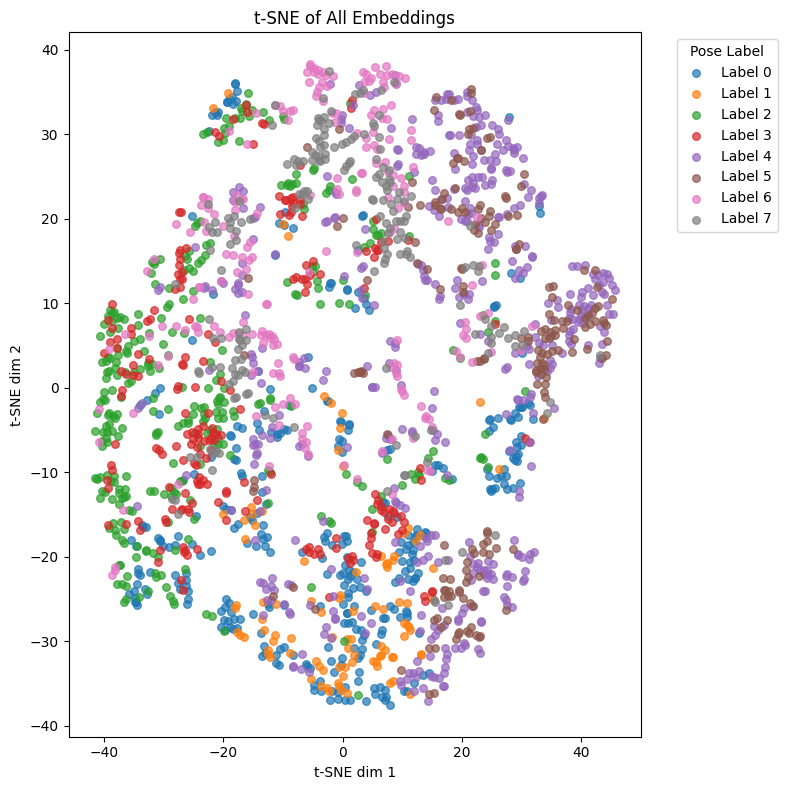

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plot_all = True        # True = plot every point; False = plot only the chosen episode
episode_index = 2       # change to the kth episode you want (0-based)

# 1) Prepare full embedding matrix
all_embeddings = np.vstack(viz_data['embedding'].values)

# 2) Dimensionality reduction on the full set
pca = PCA(n_components=50, random_state=42)
X_pca_all = pca.fit_transform(all_embeddings)

tsne = TSNE(
    n_components=2,
    init='pca',
    perplexity=50,
    learning_rate=200,
    n_iter=1000,
    random_state=42,
)
X_tsne_all = tsne.fit_transform(X_pca_all)

# 3) Figure out which episode that actually is
unique_eps = viz_data['episode'].unique()
if episode_index < 0 or episode_index >= len(unique_eps):
    raise IndexError(f"episode_index must be in [0, {len(unique_eps)-1}]")
target_ep = unique_eps[episode_index]

# 4) Build mask for that episode
mask = (viz_data['episode'] == target_ep).values

# 5) Select points & labels depending on the toggle
if plot_all:
    pts = X_tsne_all
    labels = viz_data['pose_label'].values
    title = "t-SNE of All Embeddings"
else:
    pts = X_tsne_all[mask]
    labels = viz_data.loc[mask, 'pose_label'].values
    title = f"t-SNE of embeddings for Episode #{target_ep} (index {episode_index})"

# 6) Plot
plt.figure(figsize=(8, 8))
for lbl in np.unique(labels):
    sel = (labels == lbl)
    plt.scatter(
        pts[sel, 0],
        pts[sel, 1],
        label=f'Label {lbl}',
        s=30,
        alpha=0.7
    )

plt.legend(title='Pose Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(title)
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# X = your N×D array of embeddings (e.g. PCA-reduced or original)
# labels = your N-vector of 0–7 pose labels
X = np.vstack(viz_data['embedding'].values)
labels = viz_data['pose_label'].values

sil_score = silhouette_score(X, labels)  
db_score  = davies_bouldin_score(X, labels)

print(f"Silhouette score: {sil_score:.3f}  (higher is better, max=1)")
print(f"Davies–Bouldin:  {db_score:.3f}  (lower is better)")

from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

clf = LogisticRegression(max_iter=2000)
cv  = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
acc = cross_val_score(clf, X, labels, cv=cv, scoring="accuracy")

print(f"Mean CV accuracy: {acc.mean():.3f} ± {acc.std():.3f}")

Silhouette score: -0.044  (higher is better, max=1)
Davies–Bouldin:  6.040  (lower is better)
Mean CV accuracy: 0.750 ± 0.015


## Analyzing Task Difficulty

In [44]:
data_set_path = "logs/datasets/no_domain_randomization_v8_simple_env"

all_episodes = glob.glob(os.path.join(data_set_path, "*episode*.pkl"))
success_ep_paths = glob.glob(os.path.join(data_set_path, "*success.pkl"))
failure_ep_paths = glob.glob(os.path.join(data_set_path, "*failure.pkl"))

In [45]:
def get_task_diff_datapoints(episode_paths):
    data_points = []
    for episode_path in episode_paths:
        df = pd.read_pickle(episode_path)
        # get the info from the first frame
        goal_pose = df.goal_poses[0][0]
        start_pose = df.block_poses[0][0]

        goal_pos = goal_pose[:2]/512 # put into 0-1 range
        goal_rot = goal_pose[2]
        start_pos = start_pose[:2]/512 # put into 0-1 range
        start_rot = start_pose[2] % (2*np.pi)

        # print("goal rot, start rot", goal_rot, ", ", start_rot)

        # compute distance from start to goal positions
        dist = np.linalg.norm(goal_pos - start_pos)
        rot_diff = goal_rot - start_rot

        data_points.append([dist, rot_diff])
    return np.array(data_points)

success_ep_diff = get_task_diff_datapoints(success_ep_paths)
failure_ep_diff = get_task_diff_datapoints(failure_ep_paths)

success_ep_diff.shape, failure_ep_diff.shape

((97, 2), (103, 2))

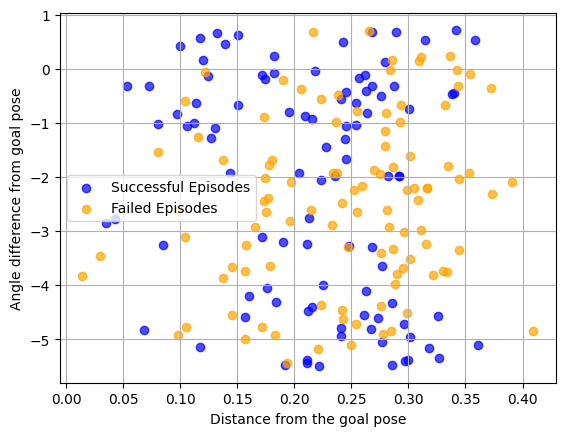

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Scatter plots
ax.scatter(success_ep_diff[:, 0], success_ep_diff[:, 1],
           label='Successful Episodes', color='blue', alpha=0.7)
ax.scatter(failure_ep_diff[:, 0], failure_ep_diff[:, 1],
           label='Failed Episodes', color='orange', alpha=0.7)

# Labels and legend
ax.set_xlabel('Distance from the goal pose')
ax.set_ylabel('Angle difference from goal pose')
ax.legend()
# Grid
ax.grid(True)
# Display
plt.show()

There does not seem to be a ton any correlation between difference from the goal pose to start pose and the outcome of the rollout.

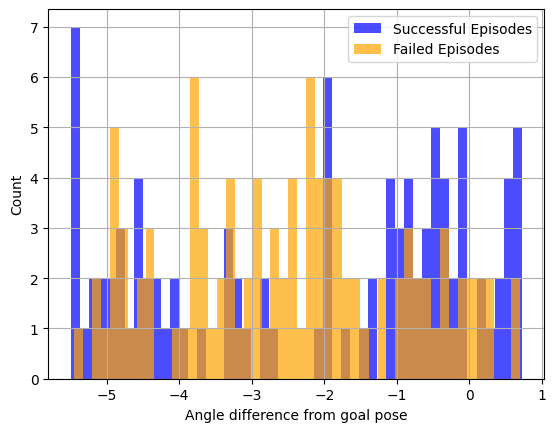

In [48]:
# Extract the y-values (angle differences)
successful_angles = success_ep_diff[:, 1]
failed_angles     = failure_ep_diff[:, 1]

# Choose number of bins (or use 'auto')
n_bins = 50

fig, ax = plt.subplots()

# Plot both histograms on the same axes
ax.hist(successful_angles,
        bins=n_bins,
        color='blue',
        alpha=0.7,
        label='Successful Episodes')
ax.hist(failed_angles,
        bins=n_bins,
        color='orange',
        alpha=0.7,
        label='Failed Episodes')

# Labels, legend, grid
ax.set_xlabel('Angle difference from goal pose')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True)

plt.show()

## Basic Dataset Statistics

In [ ]:
def get_episode_duration(ep_path):
    df = pd.read_pickle(ep_path)
    return df.timestep.max()


def get_episode_durations(data_set_path):
    # find all picks ending in success/failure
    success_ep_paths = glob.glob(os.path.join(data_set_path, "*success.pkl"))
    failure_ep_paths = glob.glob(os.path.join(data_set_path, "*failure.pkl"))

    # correctly call get_episode_duration
    success_durations = [get_episode_duration(ep) for ep in success_ep_paths]
    failure_durations = [get_episode_duration(ep) for ep in failure_ep_paths]

    return np.array(success_durations), np.array(failure_durations)

def get_success_rate(dataset_path):
    all_episodes = glob.glob(os.path.join(dataset_path, "*episode*.pkl"))
    success_ep_paths = glob.glob(os.path.join(dataset_path, "*success.pkl"))

    success_rate = len(success_ep_paths) / len(all_episodes)

    return success_rate
    

dataset_paths = ['logs/datasets/no_domain_randomization_v8_simple_env',
                  'logs/datasets/no_domain_randomization_v9_valid', 
                  'logs/datasets/domain_randomization_v1',
                  'logs/datasets/domain_randomization_v2',
                  'logs/datasets/domain_randomization_v3']

dataset_labels = ['Calibration - No DR', 
                  'Validation - No DR', 
                  'OOD (Scale 1-1.3) - Light DR', 
                  'OOD (Scale 1-2.0) - Heavy DR', 
                  'OOD (Scale 0.5-1.0) - Heavy DR']

dataset_metadata = {}

for idx, dataset_path in enumerate(dataset_paths):
    success_durs, failure_durs = get_episode_durations(dataset_path)
    dataset_metadata[dataset_path] = {
        "label": dataset_labels[idx],
        "sucess_rate": get_success_rate(dataset_path),
        "success_durations": success_durs,
        "failure_durations": failure_durs
    }

In [5]:
# 1) Print means
print("Mean Episode Durations\n" + "-"*25)
for meta in dataset_metadata.values():
    ms = meta['success_durations'].mean() if len(meta['success_durations'])>0 else float('nan')
    dev = meta['success_durations'].std()
    count = len(meta['success_durations'])
    print(f"{meta['label']}:  Success Mean = {ms:.2f}  Std Dev = {dev:.2f}; Success Rate: {meta['sucess_rate']:.3f} Count: {count}")

Mean Episode Durations
-------------------------
Calibration - No DR:  Success Mean = 159.84  Std Dev = 64.09; Success Rate: 0.485 Count: 97
Validation - No DR:  Success Mean = 149.12  Std Dev = 59.56; Success Rate: 0.500 Count: 25
OOD (Scale 1-1.3) - Light DR:  Success Mean = 167.62  Std Dev = 55.07; Success Rate: 0.420 Count: 21
OOD (Scale 1-2.0) - Heavy DR:  Success Mean = 149.60  Std Dev = 62.90; Success Rate: 0.200 Count: 10
OOD (Scale 0.5-1.0) - Heavy DR:  Success Mean = 162.00  Std Dev = 82.15; Success Rate: 0.160 Count: 8


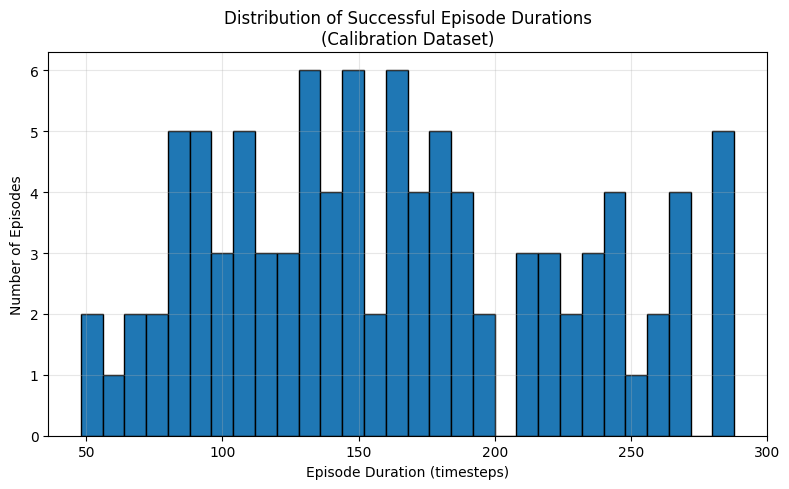

In [9]:
# pull out the successful durations array
success_durs = dataset_metadata[
    'logs/datasets/no_domain_randomization_v8_simple_env'
]['success_durations']

# plot
plt.figure(figsize=(8,5))
plt.hist(success_durs, bins=30, edgecolor='black')  # adjust bins as desired
plt.xlabel('Episode Duration (timesteps)')
plt.ylabel('Number of Episodes')
plt.title('Distribution of Successful Episode Durations\n(Calibration Dataset)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Make new dummy heuristic with blind detection threshold!

In [ ]:
from src.stac import metric_utils

quantile = 0.95
demo_success_durs = dataset_metadata['logs/datasets/no_domain_randomization_v8_simple_env']['success_durations']
demo_threshold = np.quantile(demo_success_durs, 0.95)

def compute_heuristic_results(dataset_path, threshold):
    data = dataset_metadata[dataset_path]

    success_durs = data['success_durations']
    success_preds = success_durs >= threshold
    success_labels = np.zeros_like(success_durs, dtype=bool)

    fail_durs = data['failure_durations']
    fail_preds = fail_durs >= threshold
    fail_labels = np.ones_like(fail_durs, dtype=bool)

    labels = np.concatenate([success_labels, fail_labels], axis=-1)
    preds = np.concatenate([success_preds, fail_preds], axis=-1)
    # concatenate
    metrics = metric_utils.compute_metrics(preds=preds, labels=labels, success_labels=False)
    return metrics

demo_threshold_results = compute_heuristic_results(
    'logs/datasets/no_domain_randomization_v8_simple_env',
    demo_threshold
)
demo_threshold_results

{'TP': 103,
 'TN': 92,
 'FP': 5,
 'FN': 0,
 'TPR': 1.0,
 'TNR': 0.9484536082474226,
 'FPR': 0.05154639175257732,
 'FNR': 0.0,
 'Accuracy': 0.975,
 'Balanced Accuracy': 0.9742268041237113,
 'F1 Score': 0.976303317535545}

In [22]:
demo_threshold

267.1999999999998

In [24]:
def plot_heuristic_performance(dataset_path: str,
                               demo_threshold: float,
                               max_threshold: int = 290):
    """
    Plot TPR, TNR, Balanced Accuracy and F1 Score vs detection-time threshold
    for a given dataset, and draw a vertical line at demo_threshold.
    
    Args:
        dataset_path: path key into dataset_metadata, e.g.
            'logs/datasets/no_domain_randomization_v8_simple_env'
        demo_threshold: the threshold to highlight (e.g. 95th‐quantile)
        max_threshold: upper bound (exclusive) on thresholds to sweep
    """

    dataset_label = dataset_metadata[dataset_path]['label']

    # 1. Define your thresholds
    thresholds = np.arange(0, max_threshold)

    # 2. Compute metrics for each threshold
    metrics = [
        compute_heuristic_results(dataset_path, t)
        for t in thresholds
    ]

    # 3. Extract each curve
    tpr  = [m['TPR']               for m in metrics]
    tnr  = [m['TNR']               for m in metrics]
    bacc = [m['Balanced Accuracy'] for m in metrics]
    f1   = [m['F1 Score']          for m in metrics]

    # 4. Plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, tpr,  label='TPR')
    plt.plot(thresholds, tnr,  label='TNR')
    plt.plot(thresholds, bacc, label='Balanced Accuracy')
    plt.plot(thresholds, f1,   label='F1 Score')

    # 5. Vertical line at demo_threshold
    plt.axvline(demo_threshold,
                linestyle='--',
                color='black',
                label=f'Demo Threshold = {demo_threshold:.0f}')

    # 6. Labels, legend, grid
    plt.xlabel('Detection Time Threshold')
    plt.ylabel('Metric Value')
    plt.title(f'Blind Detector Heuristic Performance - {dataset_label}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

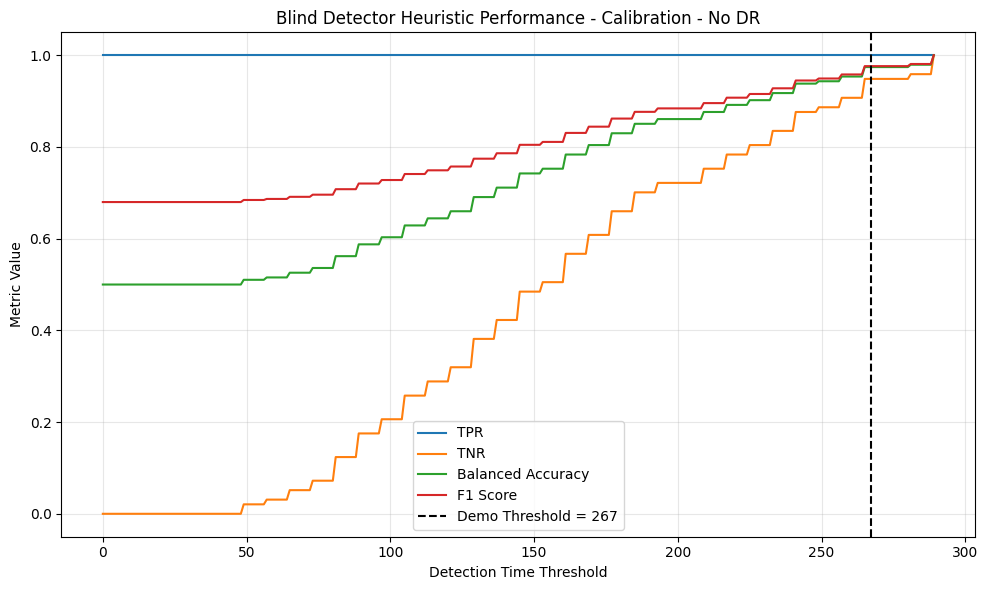

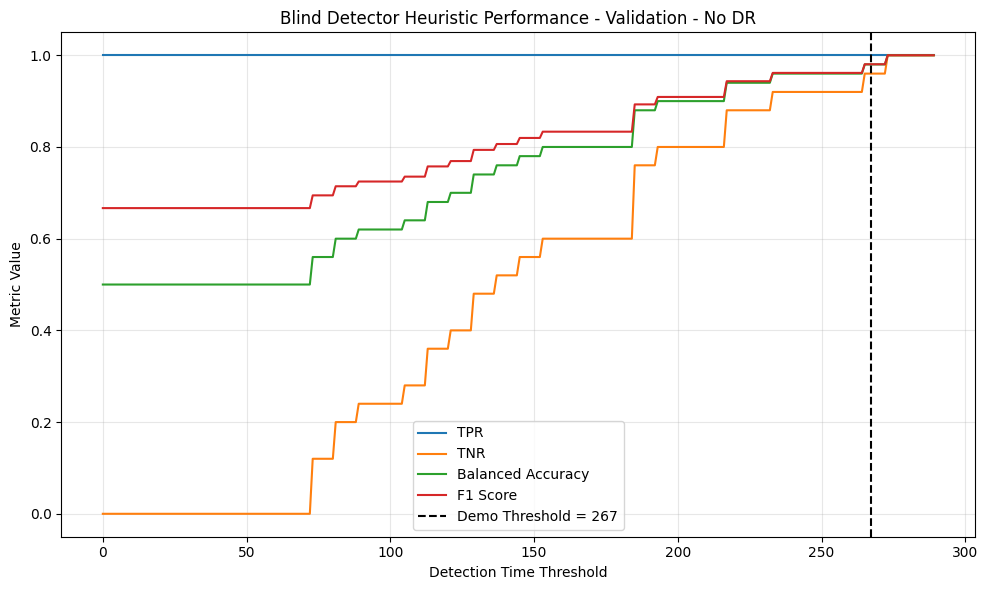

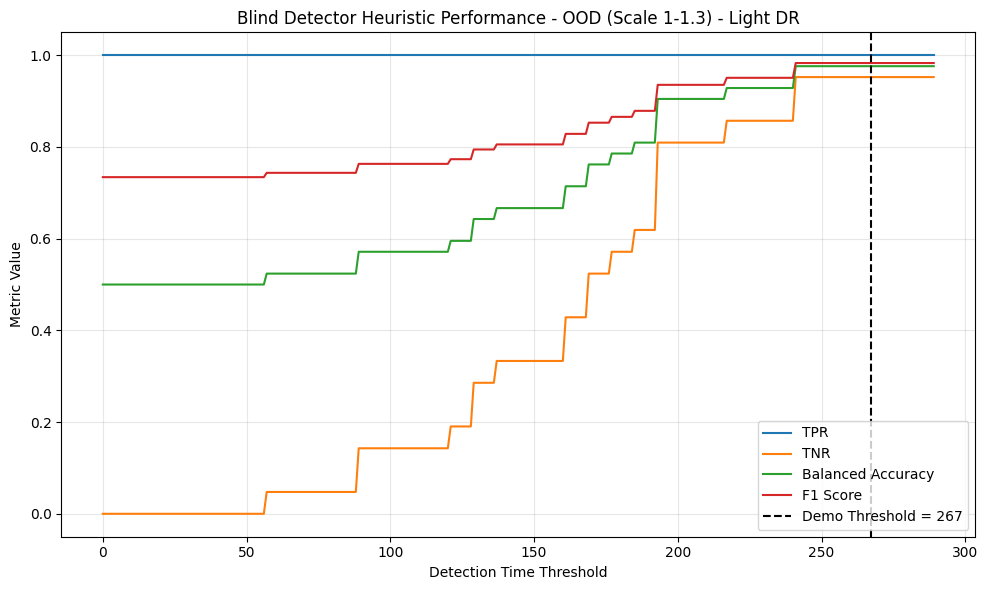

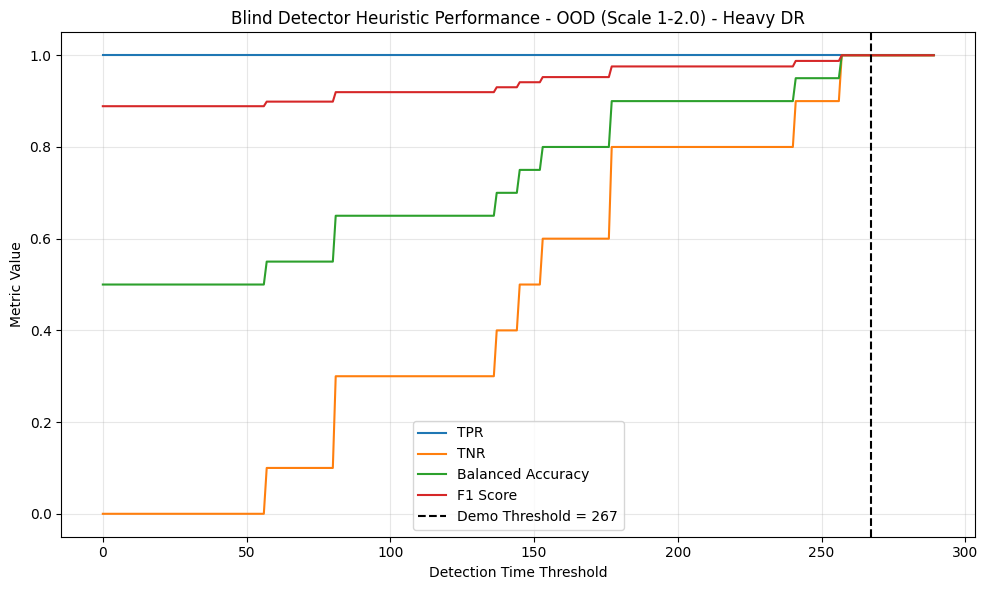

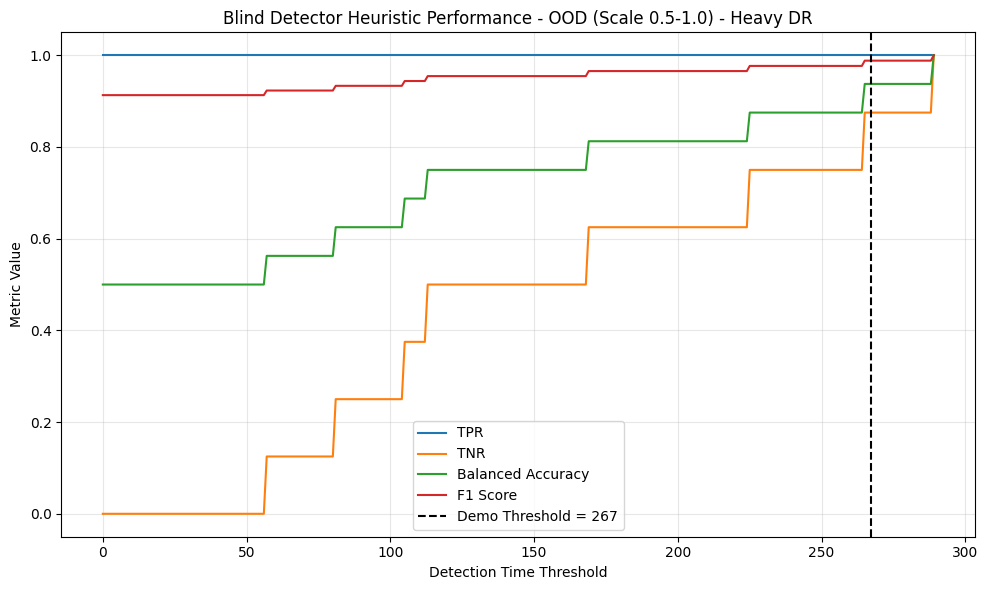

In [25]:
for path in dataset_paths:
    plot_heuristic_performance(path, demo_threshold, max_threshold=290)